MAPE (Mean Absolute Percentage Error): 6.84%
MAE (Mean Absolute Error): 8.02
RMSE (Root Mean Squared Error): 11.85


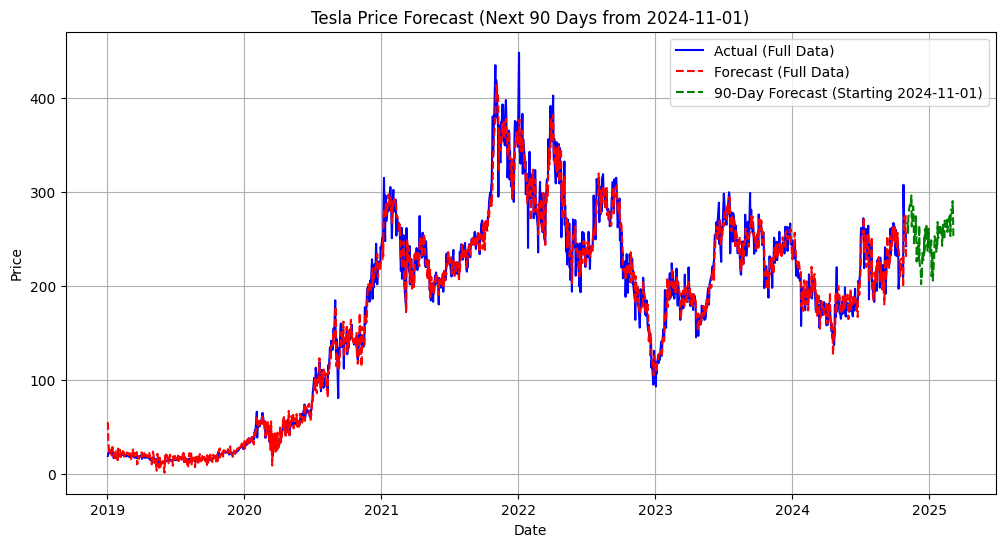

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppressing warnings to avoid clutter in the output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # Covers ValueWarning as well

# Load the dataset
testla = pd.read_csv('./Clean_data/Cleaned_Tesla_Close.csv', parse_dates=['Date'], index_col='Date')
ixic = pd.read_csv('./Clean_data/Cleaned_SP500_Close.csv', parse_dates=['Date'], index_col='Date')
sp500 = pd.read_csv('./Clean_data/Cleaned_IXIC_Close.csv', parse_dates=['Date'], index_col='Date')

# Extract predicted closing prices for S&P 500 and IXIC
sp500_predicted = sp500['Close_predicted']
ixic_predicted = ixic['Close_predicted']

# Combine predicted data into one DataFrame for exogenous variables
exog_data = pd.DataFrame({
    'Close_predicted_sp500': sp500_predicted,
    'Close_predicted_ixic': ixic_predicted,
})

# Extract Tesla's predicted closing prices
tesla_predicted = testla['Close_predicted']

# Ensure the date index of Tesla's predicted data is in datetime format
tesla_predicted.index = pd.to_datetime(tesla_predicted.index)
exog_data.index = pd.to_datetime(exog_data.index)

# Set frequency for time series data as business days ('B')
tesla_predicted = tesla_predicted.asfreq('B')
exog_data = exog_data.asfreq('B')

# Align the exogenous data and Tesla predicted data to ensure they match in terms of dates
tesla_predicted, exog_data = tesla_predicted.align(exog_data, join='inner', axis=0)

# Drop any missing values in both datasets
tesla_predicted = tesla_predicted.dropna()
exog_data = exog_data.dropna()

# Forward and backward fill any remaining missing data in exogenous variables
exog_data = exog_data.ffill().bfill()

# Replace any infinite values in exogenous data with NaN and fill them again
exog_data = exog_data.replace([np.inf, -np.inf], np.nan)
exog_data = exog_data.ffill().bfill()

# Set up SARIMAX model parameters 
p, d, q = 1, 0, 1  

# Fit SARIMAX model with Tesla predicted data as endogenous variable and the exogenous data as external predictors
model = SARIMAX(tesla_predicted, exog=exog_data,
                order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model to the data
results = model.fit()

# Get the model's fitted values 
forecast = results.fittedvalues

# Align the actual Tesla data with the forecasted values to ensure matching indices
tesla_predicted_calculation = tesla_predicted 
tesla_predicted_calculation, forecast = tesla_predicted.align(forecast, join='inner', axis=0)

# Drop any remaining missing values in the actual and forecasted data
tesla_predicted_calculation = tesla_predicted_calculation.dropna()
forecast = forecast.dropna()

# Evaluate model performance using different error metrics
mape = mean_absolute_percentage_error(tesla_predicted_calculation, forecast) * 100  # MAPE in percentage
mae = mean_absolute_error(tesla_predicted_calculation, forecast)  # MAE in absolute terms
rmse = np.sqrt(mean_squared_error(tesla_predicted_calculation, forecast))  # RMSE in absolute terms

# Print the evaluation metrics
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

# Prepare the exogenous data for the next 90-day forecast
forecast_exog = exog_data[-90:]  # Get the last 90 days of exogenous data

# Forward and backward fill any missing values for the forecast period
forecast_exog = forecast_exog.ffill().bfill()

# Generate the forecast dates (next 90 business days)
last_date = tesla_predicted.index[-1]  # Get the last date from Tesla data
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')  # 90 business days ahead

# Assign the forecast dates to the exogenous data for prediction
forecast_exog.index = forecast_dates

# Generate the forecast for the next 90 days
future_forecast = results.forecast(steps=90, exog=forecast_exog)

# Set the same index for the forecast as the forecast dates
future_forecast.index = forecast_exog.index

# Plot the results: actual data, in-sample forecast, and future forecast
plt.figure(figsize=(12, 6))  
plt.plot(tesla_predicted, label='Actual (Full Data)', color='blue')  
plt.plot(forecast, label='Forecast (Full Data)', color='red', linestyle='--') 
plt.plot(future_forecast, label='90-Day Forecast (Starting 2024-11-01)', color='green', linestyle='--') 
plt.title('Tesla Price Forecast (Next 90 Days from 2024-11-01)')  
plt.xlabel('Date') 
plt.ylabel('Price')  
plt.legend()  
plt.grid(True) 
plt.show()  